In [79]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import os, csv, shapely, shapely.wkt, descartes, geopy, pickle, cloudpickle
from shapely.geometry import Point, Polygon
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import date, datetime, timedelta
from sklearn import preprocessing
from sklearn import metrics as skm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from fairlearn.metrics import MetricFrame
from fairlearn.reductions import BoundedGroupLoss, ExponentiatedGradient, AbsoluteLoss, GridSearch
from itertools import repeat
from sklearn.model_selection import KFold

# pd.set_option('display.max_rows', 10)
# sns.set()
# sns.color_palette("ch:s=.25,rot=-.25")
np.set_printoptions(suppress=True)
# pd.options.display.float_format = '{:.2f}'.format

In [80]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

In [81]:
CITY = "P_"
save_dir = CITY + 'res/'
save_dir_preprocess = os.path.join(save_dir, CITY + 'preprocess_fig/')
save_dir_models = os.path.join(save_dir, CITY + 'model_res/') 
save_dir_forecast = os.path.join(save_dir, CITY + 'forecast/')
save_dir_fairst = os.path.join(save_dir, CITY + 'fairst/')

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
if not os.path.exists(save_dir_preprocess):
    os.makedirs(save_dir_preprocess)

if not os.path.exists(save_dir_models):
    os.makedirs(save_dir_models)
    
if not os.path.exists(save_dir_forecast):
    os.makedirs(save_dir_forecast)
    
if not os.path.exists(save_dir_fairst):
    os.makedirs(save_dir_fairst)

In [82]:
# load two datasets
df_pgh = pd.read_csv("data/pgh_grid_census.csv", index_col = 0)
df_spatially = pd.read_csv("data/spatially_sensitive_train.csv", index_col = 0)

censusTract = gpd.read_file('data/2010_Census_Tracts/a36fc9b1-4e53-4fd1-80fb-db1554e213422020328-1-nbfxcj.l6b8.shp')
geo_df = pd.read_csv("data/pgh_grid_fit.csv")[["cell_num", "geometry", "centroid"]]
geo_df.to_csv(os.path.join(save_dir_forecast, CITY +"geo_df.csv"))
geo_df.head()

,cell_num,geometry,centroid
0,51,"POLYGON ((-80.0953367046031 40.44883540123336,...",POINT (-80.09304131033451 40.45113079550194)
1,52,"POLYGON ((-80.0953367046031 40.45342618977051,...",POINT (-80.09304131033451 40.45572158403908)
2,82,POLYGON ((-80.09074591606594 40.44424461269621...,POINT (-80.08845052179737 40.44654000696479)
3,83,POLYGON ((-80.09074591606594 40.44883540123336...,POINT (-80.08845052179737 40.45113079550194)
4,84,POLYGON ((-80.09074591606594 40.45342618977051...,POINT (-80.08845052179737 40.45572158403908)


### plot station distribution

In [83]:
df_pgh_temp = df_pgh[["cell_num", "stations"]]
df_spatially_temp = df_spatially[["cell_num", "stations"]]

stations_dict = {}

for s in df_spatially_temp["cell_num"].unique():
    # print(df_spatially_temp[df_spatially_temp["cell_num"] == 628])
    stations_dict[s] = df_spatially_temp[df_spatially_temp["cell_num"] == s].iloc[-1]["stations"]
    
for stations in df_pgh_temp["cell_num"].unique():
    if stations not in stations_dict.keys():
        stations_dict[stations] = 0
        
geo_df["stations"] = 0

for index, row in geo_df.iterrows():
    row["stations"] = stations_dict[row["cell_num"]]
    geo_df.iloc[index] = row
    
for row,col in geo_df.iterrows():
    geo_df.at[row, 'geometry'] = shapely.wkt.loads(geo_df.loc[row]['geometry'])
    geo_df.at[row, 'centroid'] = shapely.wkt.loads(geo_df.loc[row]['centroid'])

In [84]:
geo_df = gpd.GeoDataFrame(geo_df, crs='EPSG:2956', geometry='geometry')
# type(pgh_grid_income.loc[0]['geometry'])

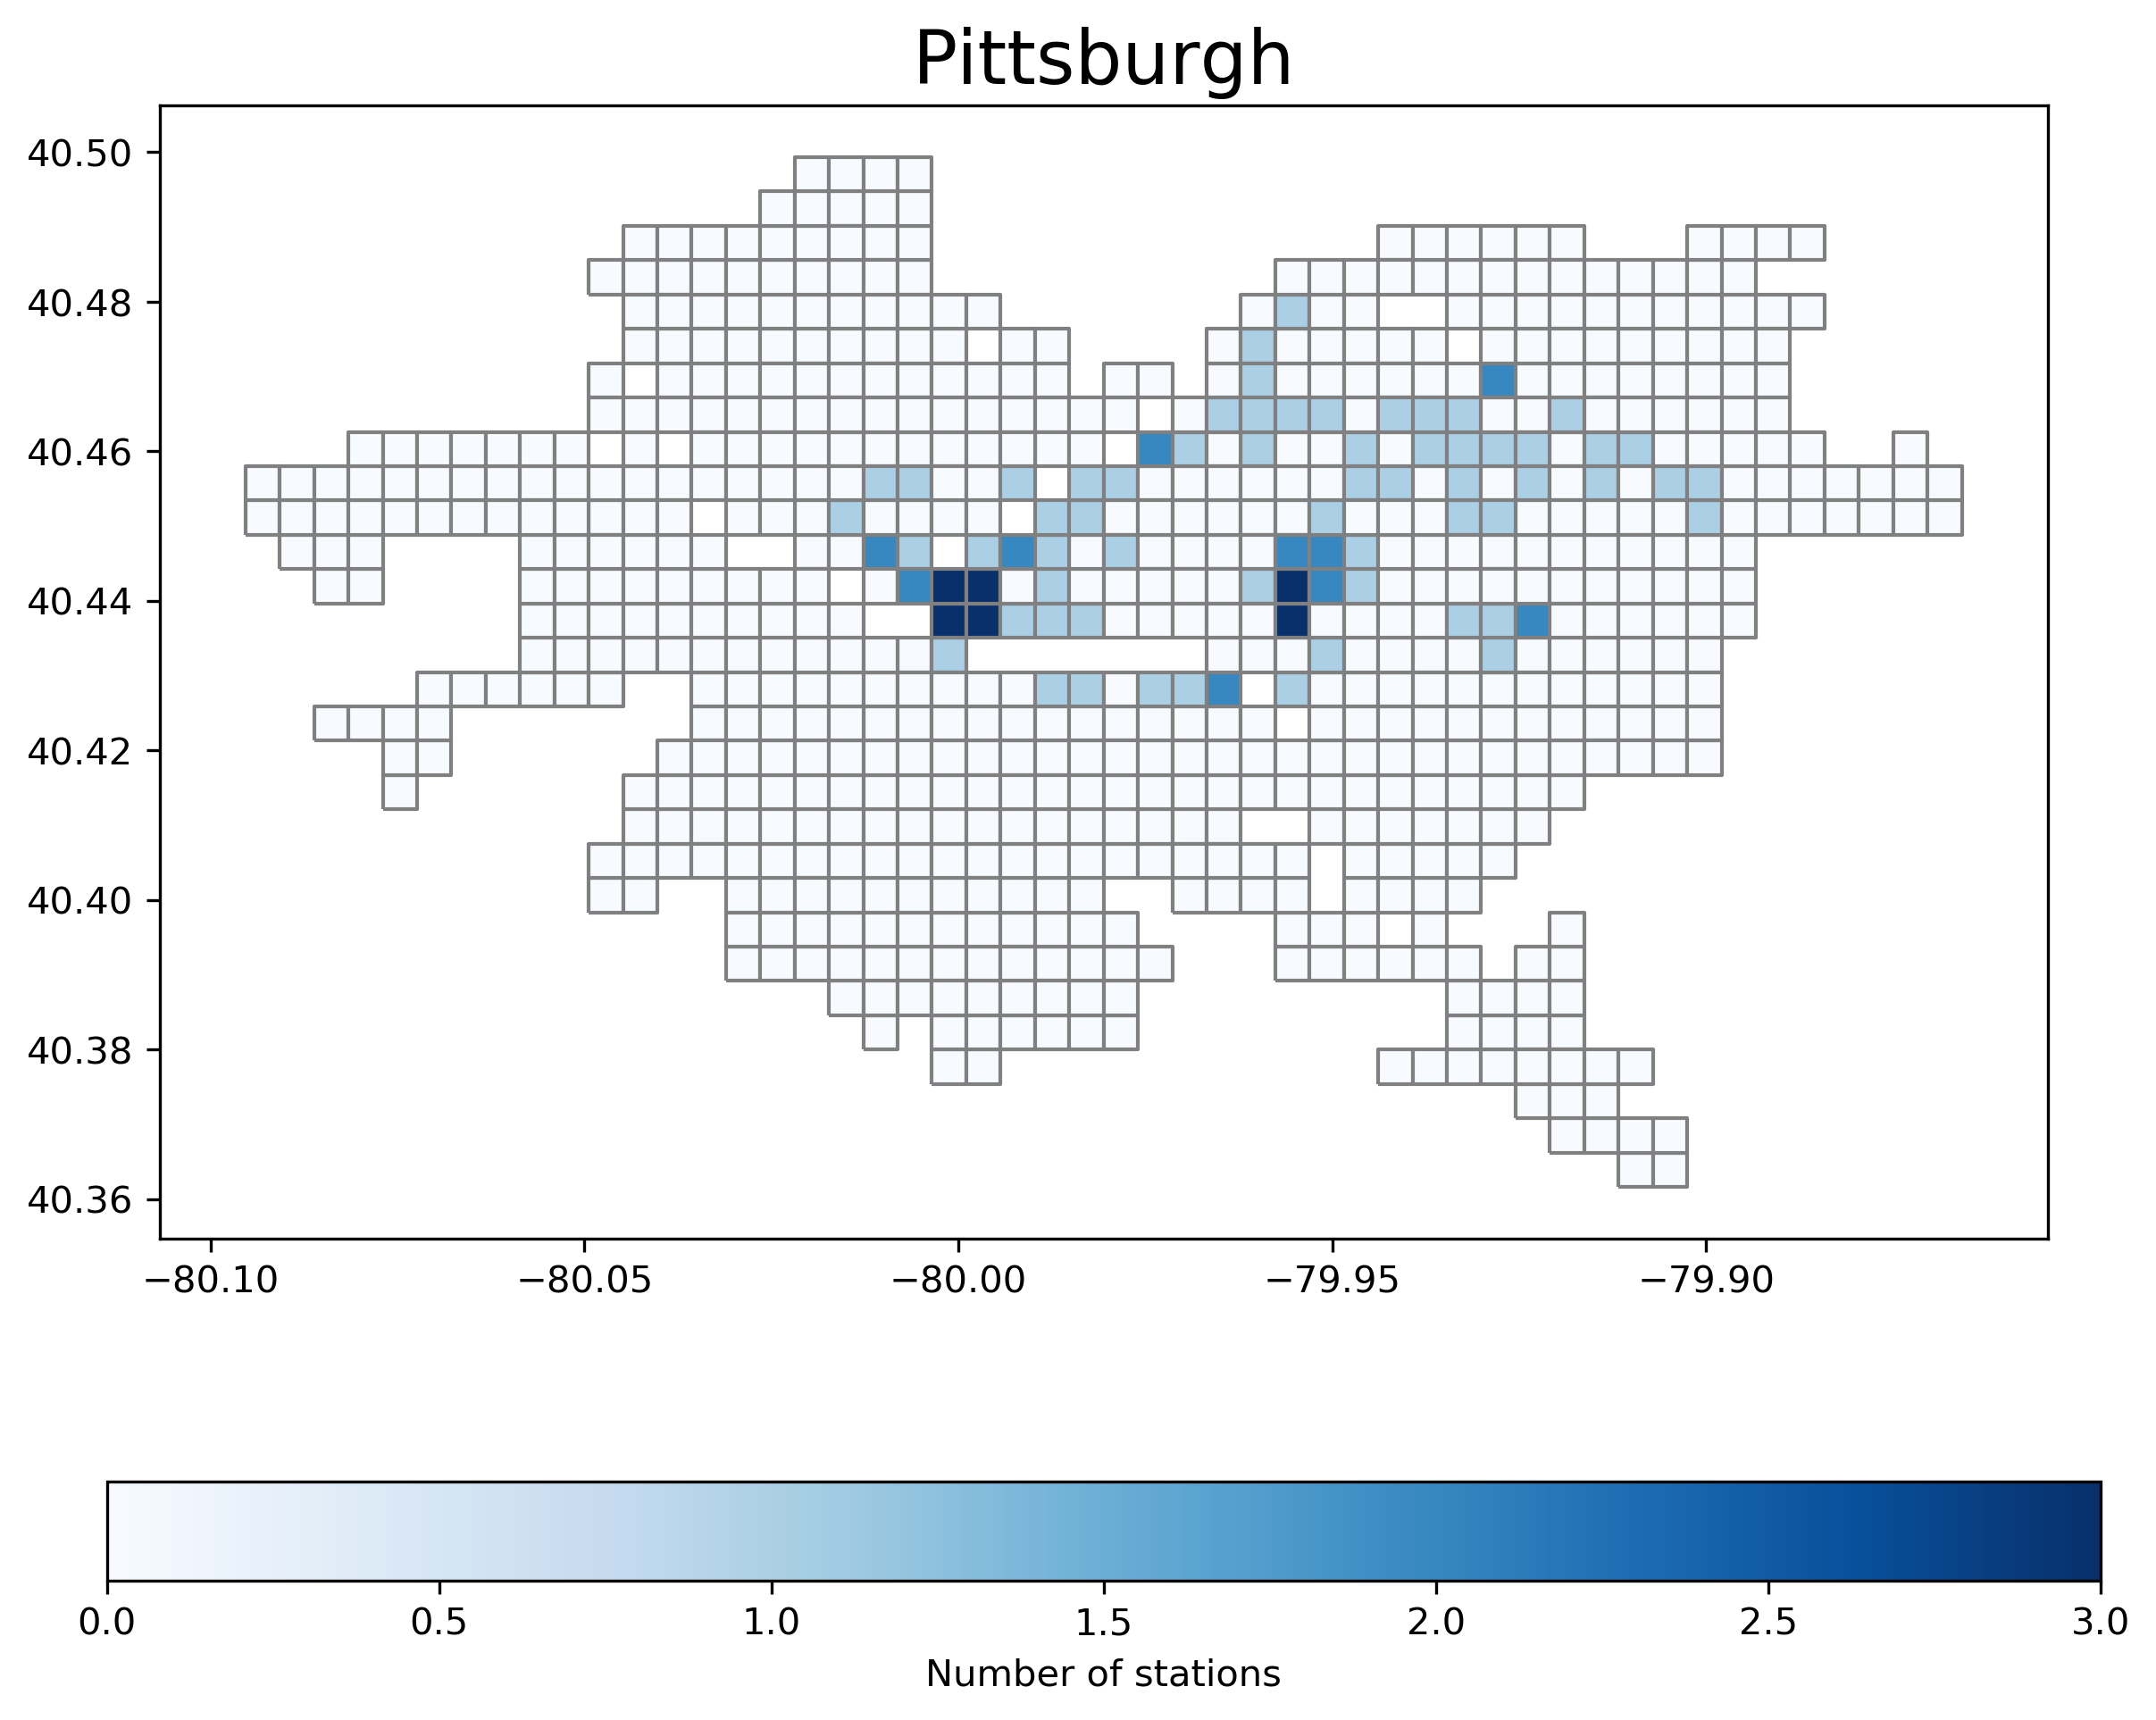

In [87]:
geo_df.plot(column="stations", cmap='Blues',edgecolor = "grey", figsize=(12, 8),  
                    legend = True, legend_kwds={'shrink': 0.8, 'label': "Number of stations",'orientation': "horizontal"})
plt.title("Distribution of stations in Pittsburgh", fontsize=20)
plt.title("Pittsburgh", fontsize = 20)
plt.savefig(os.path.join(save_dir_preprocess, CITY +"stations_dist"), facecolor = 'w')
plt.savefig("pitts_stations")

### outflow transform

In [8]:
df_outflow = df_spatially[["cell_num", "year", "month", "outflow"]]
df_outflow

,cell_num,year,month,outflow
0,687,2018,JUL,1
1,687,2018,AUG,0
2,687,2018,SEP,0
3,687,2018,OCT,0
4,687,2018,NOV,0
...,...,...,...,...
3340,1396,2020,AUG,9
3341,1396,2020,SEP,10
3342,1396,2020,OCT,6
3343,1396,2020,NOV,3


In [9]:
len(df_outflow.cell_num.unique())

76

In [10]:
def month_trans(m):
    month_num_dict = {"JAN": 1, "FEB": 2, "MAR": 3, "APR": 4,
                     "MAY": 5, "JUN": 6, "JUL": 7, "AUG": 8,
                     "SEP": 9, "OCT": 10, "NOV": 11, "DEC": 12}
    
    return month_num_dict[m]

df_outflow["month"] = df_outflow["month"].apply(lambda x: month_trans(x))
df_outflow

/Users/yhannnn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,cell_num,year,month,outflow
0,687,2018,7,1
1,687,2018,8,0
2,687,2018,9,0
3,687,2018,10,0
4,687,2018,11,0
...,...,...,...,...
3340,1396,2020,8,9
3341,1396,2020,9,10
3342,1396,2020,10,6
3343,1396,2020,11,3


In [11]:
# # Complete the missing dates & hours
# print("number of unique cells:", len(df_outflow.cell_num.unique()))
# unique_cell_ls = df_outflow.cell_num.unique()

# start_year, start_month, start_date = (2015, 5, 1)
# end_year, end_month, end_date = (2019, 12, 31)

In [12]:
# # cell2outflow = {}
# outflow_complete = pd.DataFrame()

# for i in np.arange(len(unique_cell_ls)):
#     curr_cell = unique_cell_ls[i]
#     # get outflow of that cell
#     temp = df_outflow[df_outflow.cell_num == curr_cell]
#     temp.reset_index(inplace = True, drop = True)
#     # create empty df for all time range
#     date_range = pd.date_range(date(start_year, start_month, start_date), date(end_year, end_month, end_date) + timedelta(days=1), freq='m')
#     df_outflow_monthly = pd.DataFrame({'Date': date_range})
#     df_outflow_monthly['year'] = pd.DatetimeIndex(df_outflow_monthly['Date']).year
#     df_outflow_monthly['month'] = pd.DatetimeIndex(df_outflow_monthly['Date']).month
#     df_outflow_monthly["cell_num"] = [curr_cell]*len(df_outflow_monthly)

#     df_outflow_monthly.drop(columns = ['Date'], inplace = True)

#     outflow_temp = df_outflow_monthly.merge(temp, how='left', on = ["year", "month"]).fillna(0)
#     outflow_temp.drop(columns = ["cell_num_y"], inplace = True)
#     outflow_temp.rename(columns = {"cell_num_x": "cell_num"}, inplace = True)
#     outflow_temp.outflow = outflow_temp.outflow.astype(int)
#     outflow_temp.cell_num = outflow_temp.cell_num.astype(int)
#     if i == 0:
#         outflow_complete = outflow_temp

#     else:
#         outflow_complete = outflow_complete.append(outflow_temp, ignore_index=True)
#     # create dict to record cell -> outflow df
#     # cell2outflow[curr_cell] = outflow_temp

# # Example output
# # cell2outflow[unique_cell_ls[0]]
# outflow_complete = outflow_complete[["cell_num", "year", "month", "outflow"]]
# outflow_complete

In [13]:
outflow_complete = df_outflow

### weather

In [14]:
df_weather_raw = pd.read_csv("data/weatherpgh.csv")
df_weather_raw = df_weather_raw[df_weather_raw.YEAR.isin([2015, 2016, 2017, 2018, 2019])].reset_index(drop = True)
df_weather_raw.index = df_weather_raw.YEAR
df_weather_raw.drop(columns = ["YEAR"], inplace = True)

In [15]:
df_weather_temp = pd.DataFrame(index = np.arange(12), columns = [2015, 2016, 2017, 2018, 2019])

for index, row in df_weather_raw.iterrows():
    df_weather_temp[index] = row.values[:-1]

    year_l = [2015, 2016, 2017, 2018, 2019]
month_l = list(np.arange(12) + 1)

df_weather_final = pd.DataFrame(index = np.arange(60), columns = ["temp"])
df_weather_final["year"] = [x for item in year_l for x in repeat(item, 12)]
df_weather_final["month"] = month_l*5
df_weather_final.drop(index = [0, 1, 2, 3]).reset_index(drop = True, inplace = True)
df_weather_final.head()

,temp,year,month
0,NaN,2015,1
1,NaN,2015,2
2,NaN,2015,3
3,NaN,2015,4
4,NaN,2015,5


In [16]:
for index, row in df_weather_final.iterrows():
    year = row.year
    month = row.month
    df_weather_final.loc[index, "temp"] = df_weather_temp.loc[month-1, year]
    
df_weather_final.to_csv(os.path.join(save_dir_forecast, CITY +"df_weather_final.csv"))

df_merge1 = outflow_complete.merge(df_weather_final, on = ["year", 'month'], how = 'left')

### walk score dataset

for simplicity, if stations changed, ignore --> 3d to 2d

In [17]:
# load two datasets
df_walk_score = df_spatially[["cell_num", "stations", "capacity", "walk_score", "bike_score", "transit_score", "nearby"]]
# extract parts from "nearby"

df_walk_score['nearby_bus'] = 0
df_walk_score['nearby_rail'] = 0
df_walk_score['nearby_other'] = 0
df_walk_score['nearby_routes'] = 0

for row,col in df_walk_score.iterrows():
    # if nearby == NaN
    if type(df_walk_score.loc[row]['nearby']) == float:
        df_walk_score.at[row, 'nearby_bus'] = 0
        df_walk_score.at[row, 'nearby_rail'] = 0
        df_walk_score.at[row, 'nearby_other'] = 0
        
    else:
        routes = df_walk_score.loc[row]['nearby']
        routes = routes.split(' ')
        nearby_routes = routes[0]
        nearby_bus = routes[3]
        nearby_rail = routes[5]
        nearby_other = routes[7]

        df_walk_score.at[row, 'nearby_bus'] = nearby_bus
        df_walk_score.at[row, 'nearby_rail'] = nearby_rail
        df_walk_score.at[row, 'nearby_other'] = nearby_other
        df_walk_score.at[row, 'nearby_routes'] = nearby_routes
        
df_walk_score.drop(columns = ["nearby"], inplace = True)
df_walk_score.reset_index(drop = True, inplace = True)

# censusTract

df_walk_score_temp = df_walk_score.groupby("cell_num").mean().reset_index()
for col in df_walk_score_temp.columns:
    df_walk_score_temp[col] = df_walk_score_temp[col].astype(int)
df_walk_score_temp.head()

/Users/yhannnn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/yhannnn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/yhannnn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

,cell_num,stations,capacity,walk_score,bike_score,transit_score,nearby_bus,nearby_rail,nearby_other,nearby_routes
0,595,1,19,73,66,71,38,3,0,41
1,626,2,36,62,75,92,86,3,2,91
2,628,1,5,77,87,68,52,3,0,55
3,657,2,21,98,84,99,86,3,2,91
4,658,1,15,88,80,97,87,3,2,92


In [18]:
df_merge2 = df_merge1.merge(df_walk_score_temp, on = 'cell_num', how = "left")
df_merge2

,cell_num,year,month,outflow,temp,stations,capacity,walk_score,bike_score,transit_score,nearby_bus,nearby_rail,nearby_other,nearby_routes
0,687,2018,7,1,73.5,1,10,76,82,86,58,3,2,63
1,687,2018,8,0,73.0,1,10,76,82,86,58,3,2,63
2,687,2018,9,0,69.7,1,10,76,82,86,58,3,2,63
3,687,2018,10,0,53.4,1,10,76,82,86,58,3,2,63
4,687,2018,11,0,37.3,1,10,76,82,86,58,3,2,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3340,1396,2020,8,9,NaN,1,7,60,74,63,26,0,0,26
3341,1396,2020,9,10,NaN,1,7,60,74,63,26,0,0,26
3342,1396,2020,10,6,NaN,1,7,60,74,63,26,0,0,26
3343,1396,2020,11,3,NaN,1,7,60,74,63,26,0,0,26


### census tract dataset

In [19]:
# for forecast
df_station_cap = df_spatially[["cell_num", "stations", "capacity"]].groupby("cell_num").mean().reset_index()
df_station_cap.stations = df_station_cap.stations.astype(int)
df_station_cap.capacity = df_station_cap.capacity.astype(int)
df_station_cap.to_csv(os.path.join(save_dir_forecast, CITY +"df_station_cap.csv"))

In [20]:
df_pgh_census = df_pgh[["cell_num", "median_hh_income", "population_16yrs+", "total_households", "mean_travel_time_to_work",
        "Workers_16yrs+", "perc_public", "perc_walk", "perc_other", "perc_employed", 
        "perc_unemployed", "wfh", "own_alone", "carpool"]]
df_pgh_census.to_csv(os.path.join(save_dir_forecast, CITY +"df_pgh_census.csv"))
df_pgh_census

,cell_num,median_hh_income,population_16yrs+,total_households,mean_travel_time_to_work,Workers_16yrs+,perc_public,perc_walk,perc_other,perc_employed,perc_unemployed,wfh,own_alone,carpool
0,51,67409,2660,1306,23,1695,0.156342,0.037168,0.0,0.634586,0.048120,58,1083,226
1,52,67409,2660,1306,23,1695,0.156342,0.037168,0.0,0.634586,0.048120,58,1083,226
2,82,67409,2660,1306,23,1695,0.156342,0.037168,0.0,0.634586,0.048120,58,1083,226
3,83,67409,2660,1306,23,1695,0.156342,0.037168,0.0,0.634586,0.048120,58,1083,226
4,84,67409,2660,1306,23,1695,0.156342,0.037168,0.0,0.634586,0.048120,58,1083,226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,1587,30089,2394,1391,26,1066,0.181051,0.000000,0.0,0.462824,0.070593,179,581,113
724,1588,30089,2394,1391,26,1066,0.181051,0.000000,0.0,0.462824,0.070593,179,581,113
725,1589,30089,2394,1391,26,1066,0.181051,0.000000,0.0,0.462824,0.070593,179,581,113
726,1619,30089,2394,1391,26,1066,0.181051,0.000000,0.0,0.462824,0.070593,179,581,113


___

In [21]:
# for fairst forecast
df_pgh_census_copy = df_pgh_census.copy()
df_pgh_census_copy["income_group"] = 0
df_pgh_census_copy["median_hh_income"] = df_pgh_census_copy["median_hh_income"].replace("-", 0)
df_pgh_census_copy.median_hh_income = df_pgh_census_copy.median_hh_income.astype(int)
# df_pgh_census_copy.median_hh_income.fillna(0)
for row, col in df_pgh_census_copy.iterrows():
    if df_pgh_census_copy.loc[row]["median_hh_income"] > 50000:
        df_pgh_census_copy.at[row, "income_group"] = 1
df_pgh_census_copy[["cell_num", "income_group"]].to_csv(os.path.join(save_dir_fairst, "df_income.csv"))

___

In [22]:
df = df_merge2.merge(df_pgh_census, on = "cell_num", how = 'left')
df = df.fillna(0)
df

,cell_num,year,month,outflow,temp,stations,capacity,walk_score,bike_score,transit_score,...,mean_travel_time_to_work,Workers_16yrs+,perc_public,perc_walk,perc_other,perc_employed,perc_unemployed,wfh,own_alone,carpool
0,687,2018,7,1,73.5,1,10,76,82,86,...,0,0,0.000000,0.000000,0.0,0.000000,0.000000,0,0,0
1,687,2018,8,0,73.0,1,10,76,82,86,...,0,0,0.000000,0.000000,0.0,0.000000,0.000000,0,0,0
2,687,2018,9,0,69.7,1,10,76,82,86,...,0,0,0.000000,0.000000,0.0,0.000000,0.000000,0,0,0
3,687,2018,10,0,53.4,1,10,76,82,86,...,0,0,0.000000,0.000000,0.0,0.000000,0.000000,0,0,0
4,687,2018,11,0,37.3,1,10,76,82,86,...,0,0,0.000000,0.000000,0.0,0.000000,0.000000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3340,1396,2020,8,9,0.0,1,7,60,74,63,...,28,310,0.341935,0.051613,0.0,0.309073,0.007976,28,160,0
3341,1396,2020,9,10,0.0,1,7,60,74,63,...,28,310,0.341935,0.051613,0.0,0.309073,0.007976,28,160,0
3342,1396,2020,10,6,0.0,1,7,60,74,63,...,28,310,0.341935,0.051613,0.0,0.309073,0.007976,28,160,0
3343,1396,2020,11,3,0.0,1,7,60,74,63,...,28,310,0.341935,0.051613,0.0,0.309073,0.007976,28,160,0


In [23]:
df["median_hh_income"] = df["median_hh_income"].replace("-", 0)
df.median_hh_income = df.median_hh_income.astype(int)

### income

In [24]:
print(df["median_hh_income"].describe())

count      3345.000000
mean      53813.663677
std       31303.414880
min           0.000000
25%       27003.000000
50%       54457.000000
75%       69491.000000
max      133750.000000
Name: median_hh_income, dtype: float64


In [25]:
# training set
df["income_group"] = 0
for row, col in df.iterrows():
    if df.loc[row]["median_hh_income"] > 50000:
        df.at[row, "income_group"] = 1
df.drop(columns = ["median_hh_income"], inplace = True)

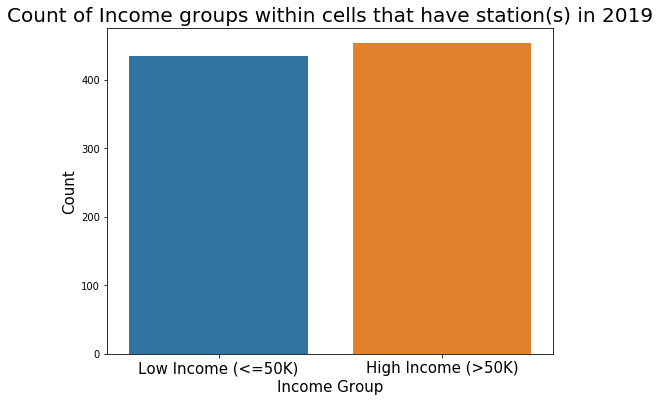

In [26]:
plt.figure(figsize = (8, 6))
sns.countplot(df[df.year == 2019]["income_group"])
plt.title("Count of Income groups within cells that have station(s) in 2019", fontsize = 20)
plt.xticks([0, 1], ["Low Income (<=50K)", "High Income (>50K)"], fontsize = 15)
plt.xlabel("Income Group", fontsize = 15)
plt.ylabel("Count", fontsize = 15)
plt.savefig(os.path.join(save_dir_preprocess, CITY +"income_group_2019"))

### feature scaling

In [27]:
# # # outflow = df["outflow"].values.reshape(-1, 1) #returns a numpy array
# # feature scaling
# columns_new = list(df.columns)
# columns_new.remove("year")
# columns_new.remove("cell_num")
# columns_new.remove('income_group')

# min_max_scaler = preprocessing.MinMaxScaler()
# df_scaled = min_max_scaler.fit_transform(df.drop(columns = ['year', 'cell_num', 'income_group']))
# df_scaled = pd.DataFrame(df_scaled, columns = columns_new)

# df_scaled["year"] = df["year"]
# df_scaled["cell_num"] = df["cell_num"]
# df_scaled["outflow"] = df["outflow"]
# df_scaled["income_group"] = df["income_group"]
# # df_scaled["stations"] = df["stations"]

# # df_scaled.outflow = min_max_scaler.fit_transform(df_scaled.outflow.values.reshape(-1, 1))

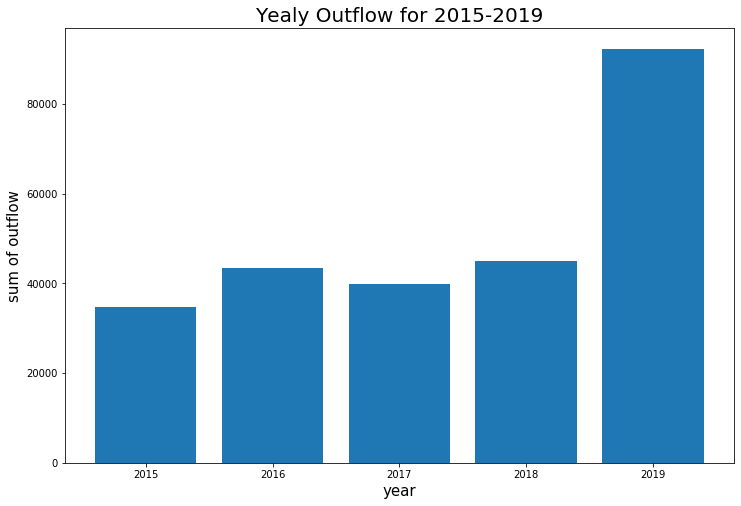

In [28]:
plt.figure(figsize = (12, 8))
plt.bar(height = 'outflow', x = "year", data = df.groupby("year").sum().reset_index()[["year", "outflow"]][:-1])
plt.title("Yealy Outflow for 2015-2019", fontsize = 20)
plt.xlabel("year", fontsize = 15)
plt.ylabel("sum of outflow", fontsize = 15)
plt.savefig(os.path.join(save_dir_preprocess, CITY +"yearly outflow"))

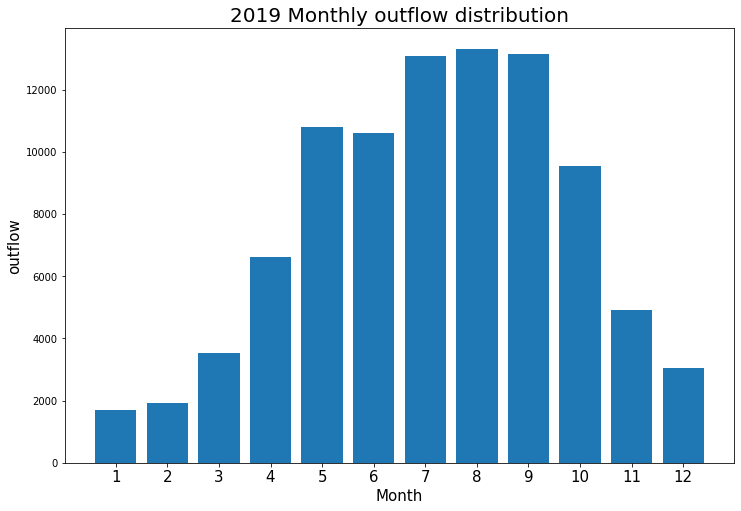

In [29]:
plt.figure(figsize = (12, 8))
plt.bar(x = df[df.year == 2019].groupby("month").sum()["outflow"].index , height = df[df.year == 2019].groupby("month").sum()["outflow"].values)
plt.title("2019 Monthly outflow distribution", fontsize = 20)
plt.xlabel("Month", fontsize = 15)
plt.ylabel("outflow", fontsize = 15)
plt.xticks(df[df.year == 2019].groupby("month").sum()["outflow"].index, fontsize = 15)
plt.savefig(os.path.join(save_dir_preprocess, CITY +"2019_monthly_outflow"))

In [31]:
# Train Test split
df_1518 = df[df["year"].isin([2015, 2016, 2017, 2018])] # 1032
df_19 = df[df["year"].isin([2019]) & ~(df["month"] == 1)]

df_1518 = df_1518.drop(columns = ["year"])
df_19 = df_19.drop(columns = ["year"])

In [32]:
df_1518.columns

Index(['cell_num', 'month', 'outflow', 'temp', 'stations', 'capacity',
       'walk_score', 'bike_score', 'transit_score', 'nearby_bus',
       'nearby_rail', 'nearby_other', 'nearby_routes', 'population_16yrs+',
       'total_households', 'mean_travel_time_to_work', 'Workers_16yrs+',
       'perc_public', 'perc_walk', 'perc_other', 'perc_employed',
       'perc_unemployed', 'wfh', 'own_alone', 'carpool', 'income_group'],
      dtype='object')

In [33]:
X_train = df_1518.drop(columns = ["outflow", "cell_num"])
X_test = df_19.drop(columns = ["outflow", "cell_num"])

y_train = df_1518["outflow"]
y_test = df_19["outflow"]

A_train = df_1518["income_group"]
A_test = df_19["income_group"]

X_train.to_csv(os.path.join(save_dir_forecast, CITY +"X_train.csv"))

y_test_cell_num = df_19[["cell_num", "income_group"]]
y_test_cell_num

,cell_num,income_group
7,687,0
8,687,0
9,687,0
10,687,0
11,687,0
...,...,...
3328,1396,0
3329,1396,0
3330,1396,0
3331,1396,0


In [34]:
# reset index
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)
A_train.reset_index(drop = True, inplace = True)
A_test.reset_index(drop = True, inplace = True)

In [35]:
# RFG calculation
def rfg_calc(y_pred, y_gt, normalized_pop_df, y_test_cell_num):
    normalized_pop_df["cell_num"] = normalized_pop_df.index
    cell2group_df = y_test_cell_num.groupby("cell_num").mean().reset_index()
    cell2group_df["income_group"] = cell2group_df["income_group"].astype(int)
    cell_pop_df = normalized_pop_df.merge(cell2group_df, on = "cell_num")
    
    g1_pop = cell_pop_df[cell_pop_df["income_group"] == 1].normalized_pop.sum()
    g2_pop = cell_pop_df[cell_pop_df["income_group"] == 0].normalized_pop.sum()
    
    group_index = A_test.reset_index(drop = True)
    g1_pred = y_pred[group_index[group_index == 1].index]
    g2_pred = y_pred[group_index[group_index == 0].index]

    bike_g1 = g1_pred.sum() / len(y_pred)
    bike_g2 = g2_pred.sum()/ len(y_pred)
    # print("bike_g1 ", bike_g1)
    # print("bike_g2 ", bike_g2)
    
    return bike_g1 /g1_pop - bike_g2 /g2_pop

In [36]:
# calculate normalized pop: for RFG
cell_num_ls = df[df.year == 2019].cell_num.unique()
normalized_pop_df = pd.DataFrame(0, columns = ['pop'] , index = cell_num_ls)
        
for cell in cell_num_ls:
    pop = df[df.year == 2019][df[df.year == 2019].cell_num == cell]['population_16yrs+'].reset_index(drop=True)[0]
    normalized_pop_df.loc[cell, 'pop'] = pop
    
normalized_pop_df["normalized_pop"] = normalized_pop_df["pop"] / normalized_pop_df["pop"].sum()
normalized_pop_df.to_csv(os.path.join(save_dir_fairst, "normalized_pop_df.csv"))

### 3 Fairness models

In [37]:
# summary df
model_summary = pd.DataFrame(0, columns = ["r2", "r2_diff", "mae", "mae_diff", "rfg"], 
                             index = ["random_forest", "exp_grad", "grid_search"])

# model_summary.to_csv(os.path.join(save_dir_models, CITY +"model_summary.csv"))

In [38]:
# param_grid = { # 'bootstrap': [True, False],
#  'max_depth': [10, 20, 40, 50, None],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5],
#  'n_estimators': [10, 20, 40, 50, None]}

# # Create a based model
# rf = RandomForestRegressor(random_state = 42)
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, verbose = 1, scoring = 'neg_mean_absolute_error') # r2 / neg_mean_absolute_error
# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)
# grid_search.best_params_

# # save grid search model
# with open(os.path.join(save_dir_models, CITY +"random_forest_gs_best.csv"), 'w') as f:
#     for key in grid_search.best_params_.keys():
#         f.write("%s,%s\n"%(key, grid_search.best_params_[key]))
#     f.write("%s, %s\n"%("scoring", grid_search.scoring))

In [39]:
# print(grid_search.best_estimator_)
# print(grid_search.best_score_)
# grid_search_all_res = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["neg_mean_absolute_error"])], axis=1)
# grid_search_all_res.to_csv(os.path.join(save_dir_models, CITY +"random_forest_gs_all.csv"))

In [40]:
rf_best = pickle.load(open(os.path.join(save_dir_models, CITY + "random_forest.pkl"), 'rb'))

R^2      0.89451
MAE    20.632744
dtype: object
------------------------------
                   R^2        MAE
income_group                     
0             0.890888  16.593615
1             0.889844  23.362004
R^2 diff: 0.00104
MAE diff: 6.76839
------------------------------


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feac66335d0>],
      dtype=object)

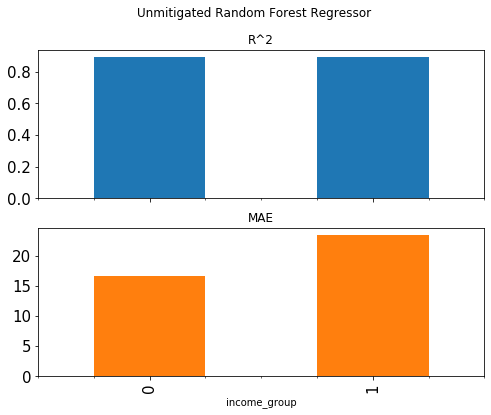

In [41]:
'''
Train set
'''

# rf_best = grid_search.best_estimator_
y_pred_rf_gs_train = rf_best.predict(X_train)

# Metric evaluation
metric_frame_rf_gs_train = MetricFrame(metric = 
                                    {"R^2": skm.r2_score,
                                    "MAE": skm.mean_absolute_error},
                                   sensitive_features = A_train,
                                   y_true = y_train,
                                   y_pred = y_pred_rf_gs_train)
print(metric_frame_rf_gs_train.overall)
print("-"*30)
print(metric_frame_rf_gs_train.by_group)
print("R^2 diff:", "{:.5f}".format(metric_frame_rf_gs_train.difference()["R^2"]))
print("MAE diff:", "{:.5f}".format(metric_frame_rf_gs_train.difference()["MAE"]))
print("-"*30)
# print("RFG:", rfg_calc(y_pred_rf_gs, y_test, normalized_pop_df, y_test_cell_num))

# # save model
# model_summary.loc["random_forest", "r2"] = metric_frame_rf_gs.overall["R^2"]
# model_summary.loc["random_forest", "mae"] = metric_frame_rf_gs.overall["MAE"]
# model_summary.loc["random_forest", "r2_diff"] = metric_frame_rf_gs.difference()["R^2"]
# model_summary.loc["random_forest", "mae_diff"] = metric_frame_rf_gs.difference()["MAE"]
# model_summary.loc["random_forest", "rfg"] = rfg_calc(y_pred_rf_gs, y_test, normalized_pop_df, y_test_cell_num)

# plot
metric_frame_rf_gs_train.by_group.plot.bar(
        subplots=True, layout=[2, 1], legend=False, figsize=[8, 6],
        title='Unmitigated Random Forest Regressor', fontsize = 15)
# plt.savefig(os.path.join(save_dir_models, CITY+"random_forest_metric"))

R^2     0.527758
MAE    49.049391
dtype: object
------------------------------
                   R^2        MAE
income_group                     
0              0.45733  41.155637
1             0.519708  56.678128
R^2 diff: 0.06238
MAE diff: 15.52249
------------------------------
RFG: 31.760029383933343


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feac5099e50>],
      dtype=object)

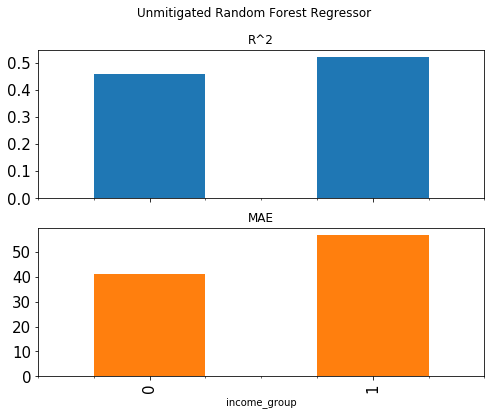

In [42]:
'''
Test set
'''
# rf_best = grid_search.best_estimator_
rf_best.fit(X_train, y_train)
y_pred_rf_gs = rf_best.predict(X_test)

# Metric evaluation
metric_frame_rf_gs = MetricFrame(metric = 
                                    {"R^2": skm.r2_score,
                                    "MAE": skm.mean_absolute_error},
                                   sensitive_features = A_test,
                                   y_true = y_test,
                                   y_pred = y_pred_rf_gs)
print(metric_frame_rf_gs.overall)
print("-"*30)
print(metric_frame_rf_gs.by_group)
print("R^2 diff:", "{:.5f}".format(metric_frame_rf_gs.difference()["R^2"]))
print("MAE diff:", "{:.5f}".format(metric_frame_rf_gs.difference()["MAE"]))
print("-"*30)
print("RFG:", rfg_calc(y_pred_rf_gs, y_test, normalized_pop_df, y_test_cell_num))

# save model
model_summary.loc["random_forest", "r2"] = metric_frame_rf_gs.overall["R^2"]
model_summary.loc["random_forest", "mae"] = metric_frame_rf_gs.overall["MAE"]
model_summary.loc["random_forest", "r2_diff"] = metric_frame_rf_gs.difference()["R^2"]
model_summary.loc["random_forest", "mae_diff"] = metric_frame_rf_gs.difference()["MAE"]
model_summary.loc["random_forest", "rfg"] = rfg_calc(y_pred_rf_gs, y_test, normalized_pop_df, y_test_cell_num)

# plot
metric_frame_rf_gs.by_group.plot.bar(
        subplots=True, layout=[2, 1], legend=False, figsize=[8, 6],
        title='Unmitigated Random Forest Regressor', fontsize = 15)

# plt.savefig(os.path.join(save_dir_models, CITY +"random_forest_metric"))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feac5b48d10>],
      dtype=object)

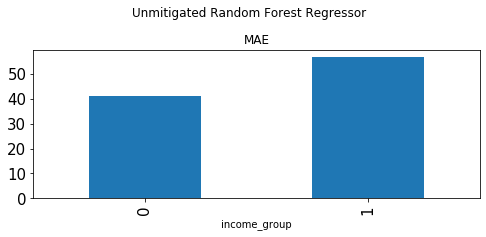

In [43]:
metric_frame_rf_gs.by_group['MAE'].plot.bar(
        subplots=True, layout=[2, 1], legend=False, figsize=[8, 6],
        title='Unmitigated Random Forest Regressor', fontsize = 15)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feac663e390>],
      dtype=object)

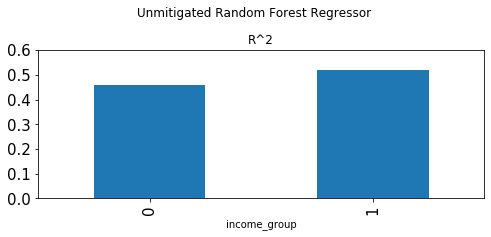

In [44]:
metric_frame_rf_gs.by_group['R^2'].plot.bar(
        subplots=True, layout=[2, 1], legend=False, figsize=[8, 6],  ylim=[0, .6],
        title='Unmitigated Random Forest Regressor', fontsize = 15)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feac50b3990>],
      dtype=object)

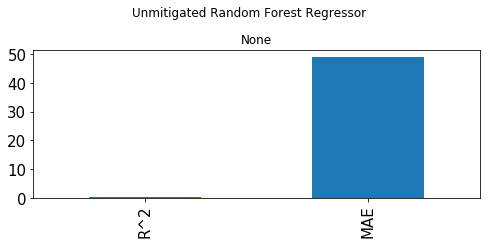

In [45]:
metric_frame_rf_gs.overall.plot.bar(
        subplots=True, layout=[2, 1], legend=False, figsize=[8, 6],
        title='Unmitigated Random Forest Regressor', fontsize = 15)

In [46]:
# # save model
# Pkl_Filename = "random_forest.pkl"  
# with open(os.path.join(save_dir_forecast, CITY +Pkl_Filename), 'wb') as file:  
#     pickle.dump(rf_best, file)

### 2) Exponentiated Gradient (constraint: BGL)

In [47]:
# # diff_bound_l = np.arange(0, 100000, 2000)/10000000
# # diff_bound_l = diff_bound_l[1:]
# # diff_bound_l = [0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5]

# # diff_bound_l = np.linspace(0.1, 2, 50)
# diff_bound_l = np.linspace(0, 5, 30)
# diff_bound_l

In [48]:
# # cross validation for EG
# # implement K-fold cross validation

# exp_grad_result = pd.DataFrame({"diff_bound": diff_bound_l})

# for i in range(len(diff_bound_l)):
#     cv_r2_ls = []
#     cv_mae_ls = []
#     cv_r2_diff_ls = []
#     cv_mae_diff_ls = []
    
#     print(i)
#     diff_bound = diff_bound_l[i]
    
#     # train-valid split
#     kfold = KFold(3, shuffle = True, random_state = 42)
#     for train, valid in kfold.split(X_train):
#         # print("CV")
#         X_train_exp = X_train.loc[train]
#         y_train_exp = y_train.loc[train]
#         A_train_exp = A_train.loc[train]

#         X_valid = X_train.loc[valid]
#         y_valid = y_train.loc[valid]
#         A_valid = A_train.loc[valid]

#         # avoid failure of optimization
#         try:
#             # train
#             constraint = BoundedGroupLoss(loss = AbsoluteLoss(-np.inf, np.inf), upper_bound = diff_bound)
#             exp_grad = ExponentiatedGradient(estimator = rf_best, constraints = constraint)
#             exp_grad.fit(X_train_exp, y_train_exp, sensitive_features = A_train_exp)
#             y_valid_pred = exp_grad.predict(X_valid, random_state = 42)

#             # performance validation #
#             metric_frame_eg_cv = MetricFrame(metric = {"R^2": skm.r2_score,  "MAE": skm.mean_absolute_error},
#                                             sensitive_features = A_valid, y_true = y_valid, y_pred = y_valid_pred)

#             cv_r2_ls.append(skm.r2_score(y_valid, y_valid_pred))
#             cv_mae_ls.append(skm.mean_absolute_error(y_valid, y_valid_pred))
#             cv_r2_diff_ls.append(metric_frame_eg_cv.difference()["R^2"])
#             cv_mae_diff_ls.append(metric_frame_eg_cv.difference()["MAE"])

#         except:
#             cv_r2_ls.append(np.nan)
#             cv_mae_ls.append(np.nan)
#             cv_r2_diff_ls.append(np.nan)
#             cv_mae_diff_ls.append(np.nan)

#     exp_grad_result.loc[i, "cv_avg_r2"] = np.nanmean(np.array(cv_r2_ls))
#     exp_grad_result.loc[i, "cv_avg_r2_diff"] = np.nanmean(np.array(cv_r2_diff_ls))
#     exp_grad_result.loc[i, "cv_avg_mae"] = np.nanmean(np.array(cv_mae_ls))
#     exp_grad_result.loc[i, "cv_avg_mae_diff"] = np.nanmean(np.array(cv_mae_diff_ls))

#     exp_grad_result.to_csv(os.path.join(save_dir_models, CITY +"exp_grad_valid_res.csv"))

In [49]:
# exp_grad_result

In [50]:
# best_eg_index = exp_grad_result[exp_grad_result.cv_avg_mae_diff == exp_grad_result.cv_avg_mae_diff.min()].index[0]
# print("best upper bound for BGL:", diff_bound_l[best_eg_index])

# # plot
# plt.figure(figsize = (25, 8))
# plt.plot(exp_grad_result.diff_bound, exp_grad_result.cv_avg_mae_diff)
# plt.scatter(exp_grad_result.iloc[exp_grad_result.cv_avg_mae_diff.argmin()].diff_bound, exp_grad_result.iloc[exp_grad_result.cv_avg_mae_diff.argmin()].cv_avg_mae_diff, color = "red")
# # plt.scatter(x = eg_result.diff_bound, y = eg_result.MSE_diff)
# plt.xlabel("upper bound in BGL", fontsize = 15)
# plt.ylabel("MAE difference", fontsize = 15)
# plt.text(x = exp_grad_result.iloc[exp_grad_result.cv_avg_mae_diff.argmin()].diff_bound+0.0005, y = exp_grad_result.iloc[exp_grad_result.cv_avg_mae_diff.argmin()].cv_avg_mae_diff, s = 'min', color = "red")
# plt.title("Cross Validation MAE diff for parameter 'upper_bound' \nin Bounded Group Loss for Exponentiated Gradient", fontsize = 18)
# plt.title("Exponentiated Gradient cross validation result: MAE difference vs. 'upper_bound' in BGL ", fontsize = 18)
# plt.savefig(os.path.join(save_dir_models, CITY +"exp_grad_valid_res"))

In [51]:
eg_best = cloudpickle.load(open(os.path.join(save_dir_models, CITY + "exp_grad.pkl"), 'rb'))
y_pred_eg = eg_best.predict(X_test, random_state = 42)

In [52]:
# # predict on test set
# eg_best = ExponentiatedGradient(estimator = rf_best, 
#                               constraints = BoundedGroupLoss(loss = AbsoluteLoss(-np.inf, np.inf), 
#                               upper_bound = diff_bound_l[best_eg_index]))

# eg_best.fit(X_train, y_train, sensitive_features = A_train)
# y_pred_eg = eg_best.predict(X_test, random_state = 42)

In [53]:
# # save model
# Pkl_Filename = "exp_grad.pkl"  
# with open(os.path.join(save_dir_forecast, CITY +Pkl_Filename), 'wb') as file:  
#     cloudpickle.dump(eg_best, file)

R^2     0.895787
MAE    20.876457
dtype: object
------------------------------
                   R^2        MAE
income_group                     
0             0.885444  17.850443
1             0.893621   22.92115

R^2 diff: 0.008176403374007601
MAE diff: 5.070706896953656
------------------------------


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feac59fa750>],
      dtype=object)

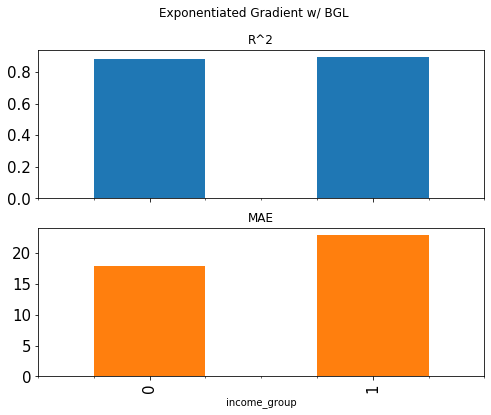

In [54]:
'''
TRAINING SET
'''
y_train_pred = eg_best.predict(X_train, random_state = 42)
metric_frame_eg_train = MetricFrame(metric = {"R^2": skm.r2_score,
                                       "MAE": skm.mean_absolute_error},
                           sensitive_features = A_train,
                           y_true = y_train,
                           y_pred = y_train_pred)

print(metric_frame_eg_train.overall)
print("-"*30)
print(metric_frame_eg_train.by_group)
print()
# print("R^2 diff:", "{:.5f}".format(metric_frame_eg.difference()["R^2"]))
print("R^2 diff:",metric_frame_eg_train.difference()["R^2"])
# print("MAE diff:", "{:.5f}".format(metric_frame_eg.difference()["MAE"]))
print("MAE diff:", metric_frame_eg_train.difference()["MAE"])
print("-"*30)
# print("RFG:", rfg_calc(y_train_pred, y_train, normalized_pop_df, y_test_cell_num))

# save model
# model_summary.loc["exp_grad", "r2"] = metric_frame_eg.overall["R^2"]
# model_summary.loc["exp_grad", "mae"] = metric_frame_eg.overall["MAE"]
# model_summary.loc["exp_grad", "r2_diff"] = metric_frame_eg.difference()["R^2"]
# model_summary.loc["exp_grad", "mae_diff"] = metric_frame_eg.difference()["MAE"]
# model_summary.loc["exp_grad", "rfg"] = rfg_calc(y_pred_eg, y_test, normalized_pop_df, y_test_cell_num)

metric_frame_eg_train.by_group.plot.bar(
        subplots=True, layout=[2, 1], legend=False, figsize=[8, 6],
        title='Exponentiated Gradient w/ BGL', fontsize = 15)
# plt.savefig(os.path.join(save_dir_models, CITY+"exp_grad_metric"))

R^2     0.583795
MAE    47.491772
dtype: object
------------------------------
                   R^2        MAE
income_group                     
0             0.481109  42.195074
1              0.59657  52.610643

R^2 diff: 0.11546045701224394
MAE diff: 10.415568295747157
------------------------------
RFG: 31.971866315695294


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feac5a167d0>],
      dtype=object)

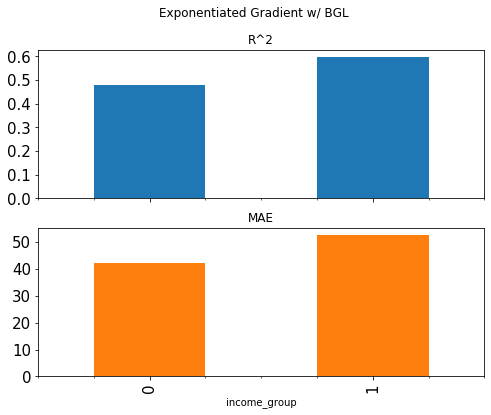

In [55]:
'''
TEST SET
'''
metric_frame_eg = MetricFrame(metric = {"R^2": skm.r2_score,
                                       "MAE": skm.mean_absolute_error},
                           sensitive_features = A_test,
                           y_true = y_test,
                           y_pred = y_pred_eg)

print(metric_frame_eg.overall)
print("-"*30)
print(metric_frame_eg.by_group)
print()
# print("R^2 diff:", "{:.5f}".format(metric_frame_eg.difference()["R^2"]))
print("R^2 diff:",metric_frame_eg.difference()["R^2"])
# print("MAE diff:", "{:.5f}".format(metric_frame_eg.difference()["MAE"]))
print("MAE diff:", metric_frame_eg.difference()["MAE"])
print("-"*30)
print("RFG:", rfg_calc(y_pred_eg, y_test, normalized_pop_df, y_test_cell_num))

# save model
model_summary.loc["exp_grad", "r2"] = metric_frame_eg.overall["R^2"]
model_summary.loc["exp_grad", "mae"] = metric_frame_eg.overall["MAE"]
model_summary.loc["exp_grad", "r2_diff"] = metric_frame_eg.difference()["R^2"]
model_summary.loc["exp_grad", "mae_diff"] = metric_frame_eg.difference()["MAE"]
model_summary.loc["exp_grad", "rfg"] = rfg_calc(y_pred_eg, y_test, normalized_pop_df, y_test_cell_num)

metric_frame_eg.by_group.plot.bar(
        subplots=True, layout=[2, 1], legend=False, figsize=[8, 6],
        title='Exponentiated Gradient w/ BGL', fontsize = 15)
# plt.savefig(os.path.join(save_dir_models, CITY +"exp_grad_metric"))

### 3) Grid Search (constraint: BGL)

In [56]:
# def calc_dominant_avg_res(predictors, X_valid, y_valid, A_valid):
    
#     # Loop through all predictors
#     r2_all = []
#     mae_diff_all = []

#     for i in range(len(predictors)):
#         metric_frame = MetricFrame(metric = {"R^2": skm.r2_score, "MAE": skm.mean_absolute_error}, sensitive_features = A_valid,
#                                    y_true = y_valid, y_pred = predictors[i].predict(X_valid))
#         mae_diff_all.append(metric_frame.difference()['MAE'])
#         r2_all.append(metric_frame.overall["R^2"])
    
#     # get dominant models
#     all_results = pd.DataFrame({"predictors:": predictors, "r2": r2_all, "diff": mae_diff_all})
#     dominated = []
#     for row in all_results.itertuples():
#         '''
#         want the models that have the high R^2 with low difference
#         thus, we select model M if all of other models with higher R^2 than M also have higher difference than M.
#         # i.e. M has the lowest difference among all of the models that have higher R^2 than it.
#         '''
#         difference = all_results["diff"][all_results["r2"] >= row.r2]
#         if row.diff <= difference.min():
#             dominated.append(row[1])
    
#     # loop all of the dominated models
#     r2_dominated = []
#     r2_diff_dominated = []
#     mae_dominated = []
#     mae_diff_dominated = []
    
#     for i in range(len(dominated)):
#         metric_frame_dominated = MetricFrame(metric={"R^2": skm.r2_score,
#                                            "MAE": skm.mean_absolute_error
#                                            },
#                                    sensitive_features = A_valid,
#                                    y_true = y_valid,
#                                    y_pred = dominated[i].predict(X_valid))

#         r2_dominated.append(metric_frame.overall["R^2"])
#         r2_diff_dominated.append(metric_frame_dominated.difference()['R^2'])
#         mae_dominated.append(metric_frame_dominated.overall["MAE"])
#         mae_diff_dominated.append(metric_frame_dominated.difference()['MAE'])
        
#     r2_dominated = np.array(r2_dominated)
#     r2_diff_dominated = np.array(r2_diff_dominated)
#     mae_dominated = np.array(mae_dominated)
#     mae_diff_dominated = np.array(mae_diff_dominated)

#     return np.nanmean(r2_dominated), np.nanmean(r2_diff_dominated), np.nanmean(mae_dominated), np.nanmean(mae_diff_dominated), dominated

In [57]:
# # cross validation for grid search 
# # implement K-fold cross validation
# grid_size_ls = np.arange(0, 22, 2)[1:]

# grid_search_result = pd.DataFrame({"grid_size": grid_size_ls})

# for i in np.arange(len(grid_size_ls)):
#     print(i)
#     g_size = grid_size_ls[i]
    
#     # train-valid split
#     kfold = KFold(3, shuffle = True, random_state = 42)
#     for train, valid in kfold.split(X_train):
#         # print("CV")
#         X_train_gs = X_train.loc[train]
#         y_train_gs = y_train.loc[train]
#         A_train_gs = A_train.loc[train]

#         X_valid = X_train.loc[valid]
#         y_valid = y_train.loc[valid]
#         A_valid = A_train.loc[valid]

#         # avoid failure of optimization
#         try:
#             # train
#             mitigator = GridSearch(estimator = rf_best,
#                        constraints = BoundedGroupLoss(loss = AbsoluteLoss(-np.inf, np.inf), upper_bound = diff_bound_l[best_eg_index]),
#                        grid_size = g_size)

#             mitigator.fit(X_train_gs, y_train_gs, sensitive_features = A_train_gs)
#             predictors = mitigator.predictors_

#             # calculate dominant models res
#             dominant_res = calc_dominant_avg_res(predictors, X_valid, y_valid, A_valid)

#             grid_search_result.loc[i, "cv_avg_r2"] = dominant_res[0]
#             grid_search_result.loc[i, "cv_avg_r2_diff"] = dominant_res[1]
#             grid_search_result.loc[i, "cv_avg_mae"] = dominant_res[2]
#             grid_search_result.loc[i, "cv_avg_mae_diff"] = dominant_res[3]

#         except:
#             grid_search_result.loc[i, "cv_avg_r2"] = np.nan
#             grid_search_result.loc[i, "cv_avg_r2_diff"] = np.nan
#             grid_search_result.loc[i, "cv_avg_mae"] = np.nan
#             grid_search_result.loc[i, "cv_avg_mae_diff"] = np.nan

#     grid_search_result.to_csv(os.path.join(save_dir_models, CITY +"grid_search_valid_res.csv"))

In [58]:
# grid_search_result

In [59]:
# best_gs_index = grid_search_result[grid_search_result.cv_avg_mae_diff == grid_search_result.cv_avg_mae_diff.min()].index[0]
# print("best grid size for Grid Search:", grid_size_ls[best_gs_index])

# # plot
# plt.figure(figsize = (25, 8))
# plt.plot(grid_search_result.grid_size, grid_search_result.cv_avg_mae_diff)
# plt.scatter(grid_search_result.iloc[grid_search_result.cv_avg_mae_diff.argmin()].grid_size, grid_search_result.iloc[grid_search_result.cv_avg_mae_diff.argmin()].cv_avg_mae_diff, color = "red")
# # plt.scatter(x = eg_result.diff_bound, y = eg_result.MSE_diff)
# plt.xlabel("upper bound in BGL", fontsize = 15)
# plt.ylabel("MAE difference", fontsize = 15)
# plt.text(x = grid_search_result.iloc[grid_search_result.cv_avg_mae_diff.argmin()].grid_size+0.0005, y = grid_search_result.iloc[grid_search_result.cv_avg_mae_diff.argmin()].cv_avg_mae_diff, s = 'min', color = "red")
# plt.title("Cross Validation MAE diff for parameter 'upper_bound' \nin Bounded Group Loss for Exponentiated Gradient", fontsize = 18)
# plt.title("Grid Search cross validation result: MAE difference vs. 'grid_size'", fontsize = 18)
# plt.savefig(os.path.join(save_dir_models, CITY +"grid_search_valid_res"))

In [60]:
# # get all predictors according to best grid size
# mitigator = GridSearch(estimator = rf_best,
#                        constraints = BoundedGroupLoss(loss = AbsoluteLoss(-np.inf, np.inf), upper_bound = diff_bound_l[best_eg_index]),
#                        grid_size = grid_size_ls[best_gs_index])

In [61]:
# kfold = KFold(2, shuffle = True, random_state = 42)

# # randomly get train valid set
# for train, valid in kfold.split(X_train):
#     # print("CV")
#     X_train_gs = X_train.loc[train]
#     y_train_gs = y_train.loc[train]
#     A_train_gs = A_train.loc[train]

#     X_valid = X_train.loc[valid]
#     y_valid = y_train.loc[valid]
#     A_valid = A_train.loc[valid]

In [62]:
# len(predictors)

In [63]:
# # get all predictors according to best grid size
# mae_diff_all = []
# r2_all = []

# mitigator = GridSearch(estimator = rf_best,
#                        constraints = BoundedGroupLoss(loss = AbsoluteLoss(-np.inf, np.inf), upper_bound = diff_bound_l[best_eg_index]),
#                        grid_size = grid_size_ls[best_gs_index])

# mitigator.fit(X_train_gs, y_train_gs, sensitive_features = A_train_gs)
# predictors = mitigator.predictors_

In [64]:
# # get dominant model on valid set
# for i in range(len(predictors)):
#     metric_frame = MetricFrame(metric = {"R^2": skm.r2_score, "MAE": skm.mean_absolute_error}, 
#                                sensitive_features = A_valid,
#                                y_true = y_valid, 
#                                y_pred = predictors[i].predict(X_valid))
#     mae_diff_all.append(metric_frame.difference()['MAE'])
#     r2_all.append(metric_frame.overall["R^2"])


# # get dominant models
# all_results = pd.DataFrame({"predictors:": predictors, "r2": r2_all, "diff": mae_diff_all})
# gs_dominant_final = []

# for row in all_results.itertuples():
#     '''
#     want the models that have the high R^2 with low difference
#     thus, we select model M if all of other models with higher R^2 than M also have higher difference than M.
#     # i.e. M has the lowest difference among all of the models that have higher R^2 than it.
#     '''
#     difference = all_results["diff"][all_results["r2"] >= row.r2]
#     if row.diff <= difference.min():
#         gs_dominant_final.append(row[1])

In [65]:
# # loop all of the dominant models on test set
# r2_dominated = []
# mae_diff_dominated = []

# for i in range(len(gs_dominant_final)):
#     metric_frame_dominant = MetricFrame(metric={"R^2": skm.r2_score,
#                                        "MAE": skm.mean_absolute_error},
#                                sensitive_features = A_test,
#                                y_true = y_test,
#                                y_pred = gs_dominant_final[i].predict(X_test))

#     mae_diff_dominated.append(metric_frame_dominant.difference()['MAE'])
#     r2_dominated.append(metric_frame_dominant.overall["R^2"])

In [66]:
# # calculate gs model with lowest MAE diff
# gs_least_mae_idx = np.argmin(np.array(mae_diff_dominated))
# gs_least_mae_idx

In [67]:
# save grid search model
# Pkl_Filename = "grid_search.pkl"  

gs_dominant_model = pickle.load(open(os.path.join(save_dir_models, CITY + "grid_search.pkl"), 'rb'))

#### Selected Grid Search model

R^2      0.83273
MAE    27.111213
dtype: object
------------------------------
                   R^2        MAE
income_group                     
0             0.814393  22.696927
1             0.829881  30.093969

R^2 diff: 0.01549
MAE diff: 7.39704
------------------------------


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feac50a2c90>],
      dtype=object)

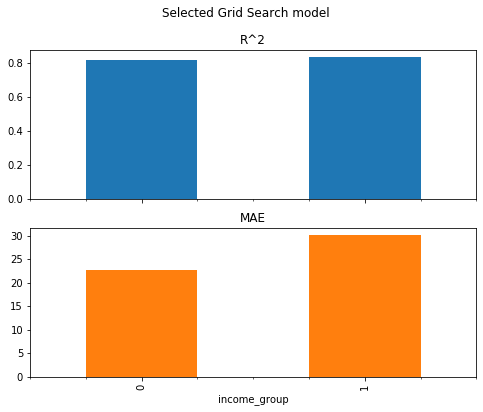

In [68]:
'''
Train set
'''
# gs_dominant_model = gs_dominant_final[gs_least_mae_idx]
y_pred_gs_train = gs_dominant_model.predict(X_train)
metric_frame_gs_train = MetricFrame(metric = {"R^2": skm.r2_score,
                                       "MAE": skm.mean_absolute_error},
                               sensitive_features = A_train,
                               y_true = y_train,
                               y_pred = y_pred_gs_train)

print(metric_frame_gs_train.overall)
print("-"*30)
print(metric_frame_gs_train.by_group)
print()
print("R^2 diff:", "{:.5f}".format(metric_frame_gs_train.difference()["R^2"]))
print("MAE diff:", "{:.5f}".format(metric_frame_gs_train.difference()["MAE"]))
print("-"*30)

# # save model
# model_summary.loc["grid_search", "r2"] = metric_frame_gs_train.overall["R^2"]
# model_summary.loc["grid_search", "mae"] = metric_frame_gs_train.overall["MAE"]
# model_summary.loc["grid_search", "r2_diff"] = metric_frame_gs_train.difference()["R^2"]
# model_summary.loc["grid_search", "mae_diff"] = metric_frame_gs_train.difference()["MAE"]
# model_summary.loc["grid_search", "rfg"] = rfg_calc(y_pred_gs, y_test, normalized_pop_df, y_test_cell_num)

# print("RFG:", rfg_calc(y_pred_gs, y_test, normalized_pop_df, y_test_cell_num))
metric_frame_gs_train.by_group.plot.bar(
        subplots=True, layout=[2, 1], legend=False, figsize=[8, 6],
        title='Selected Grid Search model')

# plt.savefig(os.path.join(save_dir_models, CITY+"grid_search_metric"))

R^2     0.574916
MAE    49.353206
dtype: object
------------------------------
                   R^2        MAE
income_group                     
0             0.473336    44.2802
1              0.58635  54.255895

R^2 diff: 0.11301
MAE diff: 9.97570
------------------------------
RFG: 30.81625576441668


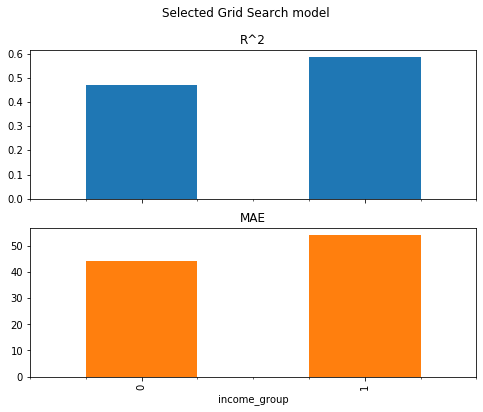

In [69]:
'''
Test set
'''
# gs_dominant_model = gs_dominant_final[gs_least_mae_idx]
y_pred_gs = gs_dominant_model.predict(X_test)
metric_frame_gs = MetricFrame(metric = {"R^2": skm.r2_score,
                                       "MAE": skm.mean_absolute_error},
                               sensitive_features = A_test,
                               y_true = y_test,
                               y_pred = y_pred_gs)

print(metric_frame_gs.overall)
print("-"*30)
print(metric_frame_gs.by_group)
print()
print("R^2 diff:", "{:.5f}".format(metric_frame_gs.difference()["R^2"]))
print("MAE diff:", "{:.5f}".format(metric_frame_gs.difference()["MAE"]))
print("-"*30)

# save model
model_summary.loc["grid_search", "r2"] = metric_frame_gs.overall["R^2"]
model_summary.loc["grid_search", "mae"] = metric_frame_gs.overall["MAE"]
model_summary.loc["grid_search", "r2_diff"] = metric_frame_gs.difference()["R^2"]
model_summary.loc["grid_search", "mae_diff"] = metric_frame_gs.difference()["MAE"]
model_summary.loc["grid_search", "rfg"] = rfg_calc(y_pred_gs, y_test, normalized_pop_df, y_test_cell_num)

print("RFG:", rfg_calc(y_pred_gs, y_test, normalized_pop_df, y_test_cell_num))
metric_frame_gs.by_group.plot.bar(
        subplots=True, layout=[2, 1], legend=False, figsize=[8, 6],
        title='Selected Grid Search model')

plt.savefig(os.path.join(save_dir_models, CITY +"grid_search_metric"))

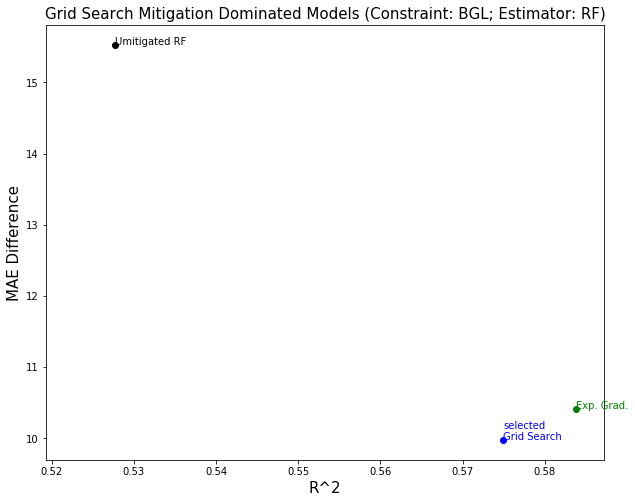

In [70]:
# plot only the dominated models

plt.figure(figsize = (10, 8))
# plt.scatter(r2_dominated, mae_diff_dominated)

# Label previous fair-unaware model
plt.scatter(metric_frame_rf_gs.overall["R^2"], metric_frame_rf_gs.difference()['MAE'], color = 'black')
plt.text(metric_frame_rf_gs.overall["R^2"], metric_frame_rf_gs.difference()['MAE'], "Umitigated RF", color = 'black')

# Selected grid search model
plt.scatter(metric_frame_gs.overall["R^2"], metric_frame_gs.difference()['MAE'], color = 'blue')
plt.text(metric_frame_gs.overall["R^2"], metric_frame_gs.difference()['MAE'], "selected\nGrid Search", color = 'blue')

# exponentiated gradient
plt.scatter(metric_frame_eg.overall['R^2'], metric_frame_eg.difference()['MAE'], color = 'green')
plt.text(metric_frame_eg.overall['R^2'], metric_frame_eg.difference()['MAE'], "Exp. Grad.", color = 'green')

plt.xlabel("R^2", fontsize = 15)
plt.ylabel("MAE Difference", fontsize = 15)
plt.title("Grid Search Mitigation Dominated Models (Constraint: BGL; Estimator: RF)", fontsize = 15)
# plt.xlim((0.806, 0.811))
plt.savefig(os.path.join(save_dir_models, CITY +"models_scatter_res"))

In [71]:
# # save grid search model
# Pkl_Filename = "grid_search.pkl"  
# with open(os.path.join(save_dir_forecast, CITY + Pkl_Filename), 'wb') as file:  
#     pickle.dump(gs_dominant_final[gs_least_mae_idx], file)

In [72]:
# save model statistics
model_summary.to_csv(os.path.join(save_dir_models, CITY +"model_summary.csv"))

### plot

Text(0.5, 1, 'Outflow Ground Truth in 2019')

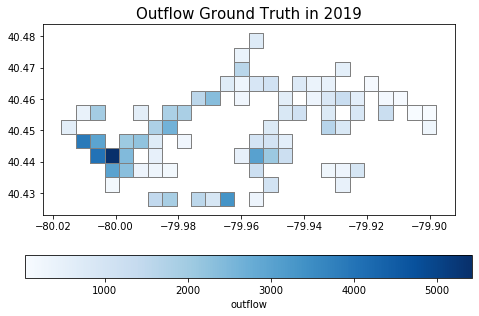

In [73]:
unmitigated_df = pd.DataFrame({ "cell_num": df_19.cell_num.values,
                                "y_pred": y_pred_rf_gs,
                                "y_true": df_19.outflow.values})
# sum within a cell
unmitigated_df = unmitigated_df.groupby("cell_num").sum()
unmitigated_df_plot = unmitigated_df.merge(geo_df, how='left', on = 'cell_num')

geo_cells_unmitigated = gpd.GeoDataFrame(unmitigated_df_plot, crs='EPSG:2956', geometry='geometry')
geo_cells_unmitigated.plot(column="y_true", cmap='Blues',edgecolor = "grey", figsize=(8, 5),  
                    legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"})
plt.title("Outflow Ground Truth in 2019", fontsize = 15)

Text(0.5, 1, 'Unmitigated random forest outflow in 2019')

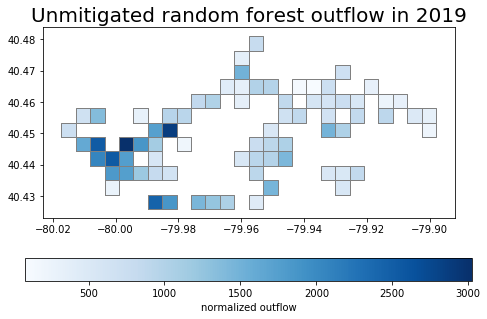

In [74]:
geo_cells_unmitigated.plot(column="y_pred", cmap='Blues',edgecolor = "grey", figsize=(8, 5),  
                    legend = True, legend_kwds={'label': "normalized outflow",'orientation': "horizontal"})
plt.title("Unmitigated random forest outflow in 2019", fontsize = 20)

Text(0.5, 1, 'Exp Grad prediction in 2019')

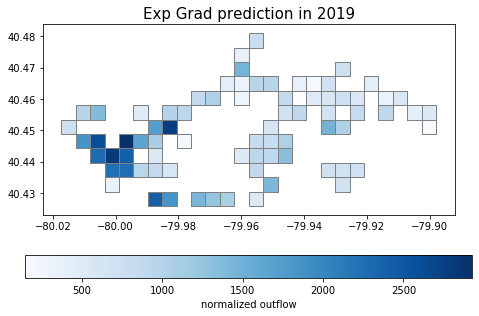

In [75]:
mitigated_eg_df = pd.DataFrame({"cell_num": df_19.cell_num.values,
                                "y_pred": y_pred_eg,
                                "y_true": y_test})
mitigated_eg_df = mitigated_eg_df.groupby("cell_num").sum()
mitigated_eg_df_plot = mitigated_eg_df.merge(geo_df, how='left', on = 'cell_num')
geo_cells_mitigated_eg = gpd.GeoDataFrame(mitigated_eg_df_plot, crs='EPSG:2956', geometry='geometry')

geo_cells_mitigated_eg.plot(column="y_pred", cmap='Blues',edgecolor = "grey", figsize=(8, 5),  
                    legend = True, legend_kwds={'label': "normalized outflow",'orientation': "horizontal"})
# plt.title("Mitigated with Exponentiated Gradient (low accuracy, low disparity)")
plt.title("Exp Grad prediction in 2019", fontsize = 15)

Text(0.5, 1, 'Grid Search prediction 2019')

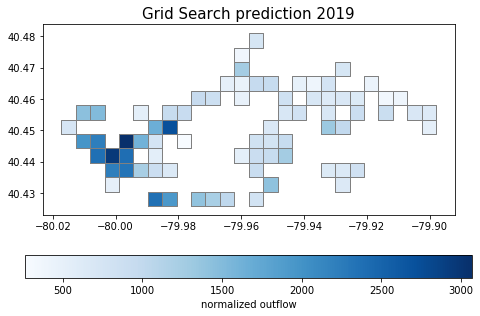

In [76]:
mitigated_gs_df = pd.DataFrame({
    # "index": y_test.index,
    "cell_num": df_19.cell_num.values,
    "y_pred": y_pred_gs,
    "y_true": y_test})
mitigated_gs_df = mitigated_gs_df.groupby("cell_num").sum()
mitigated_gs_df_plot = mitigated_gs_df.merge(geo_df, how='left', on = 'cell_num')
geo_cells_mitigated_gs = gpd.GeoDataFrame(mitigated_gs_df_plot, crs='EPSG:2956', geometry='geometry')

geo_cells_mitigated_gs.plot(column="y_pred", cmap='Blues',edgecolor = "grey", figsize=(8, 5),  
                    legend = True, legend_kwds={'label': "normalized outflow",'orientation': "horizontal"})
plt.title("Grid Search prediction 2019", fontsize = 15)

### fairST

In [73]:
fairst_pred = pd.read_csv(os.path.join(save_dir_fairst, "fairst_pred.csv"), index_col = 0)

In [74]:
for row, col in fairst_pred.iterrows():
    fairst_pred.at[row, 'geometry'] = shapely.wkt.loads(fairst_pred.loc[row]['geometry'])

Text(0.5, 1, 'fairST(lambda: 0.2) prediction in 2019')

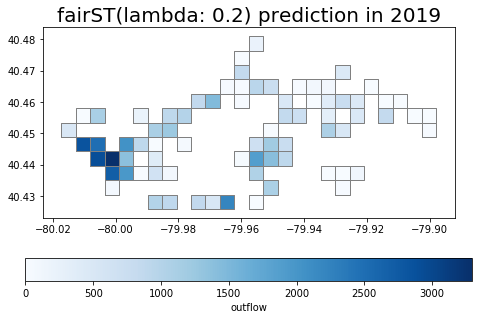

In [75]:
fairst_pred = gpd.GeoDataFrame(fairst_pred, crs='EPSG:2956', geometry='geometry')
# type(pgh_grid_income.loc[0]['geometry'])

fairst_pred.plot(column="outflow", cmap='Blues',edgecolor = "grey", figsize=(8, 5),  
                    legend = True, legend_kwds={'label': "outflow", 'orientation': "horizontal"})
plt.title("fairST(lambda: {}) prediction in 2019".format(str(0.2)), fontsize=20)

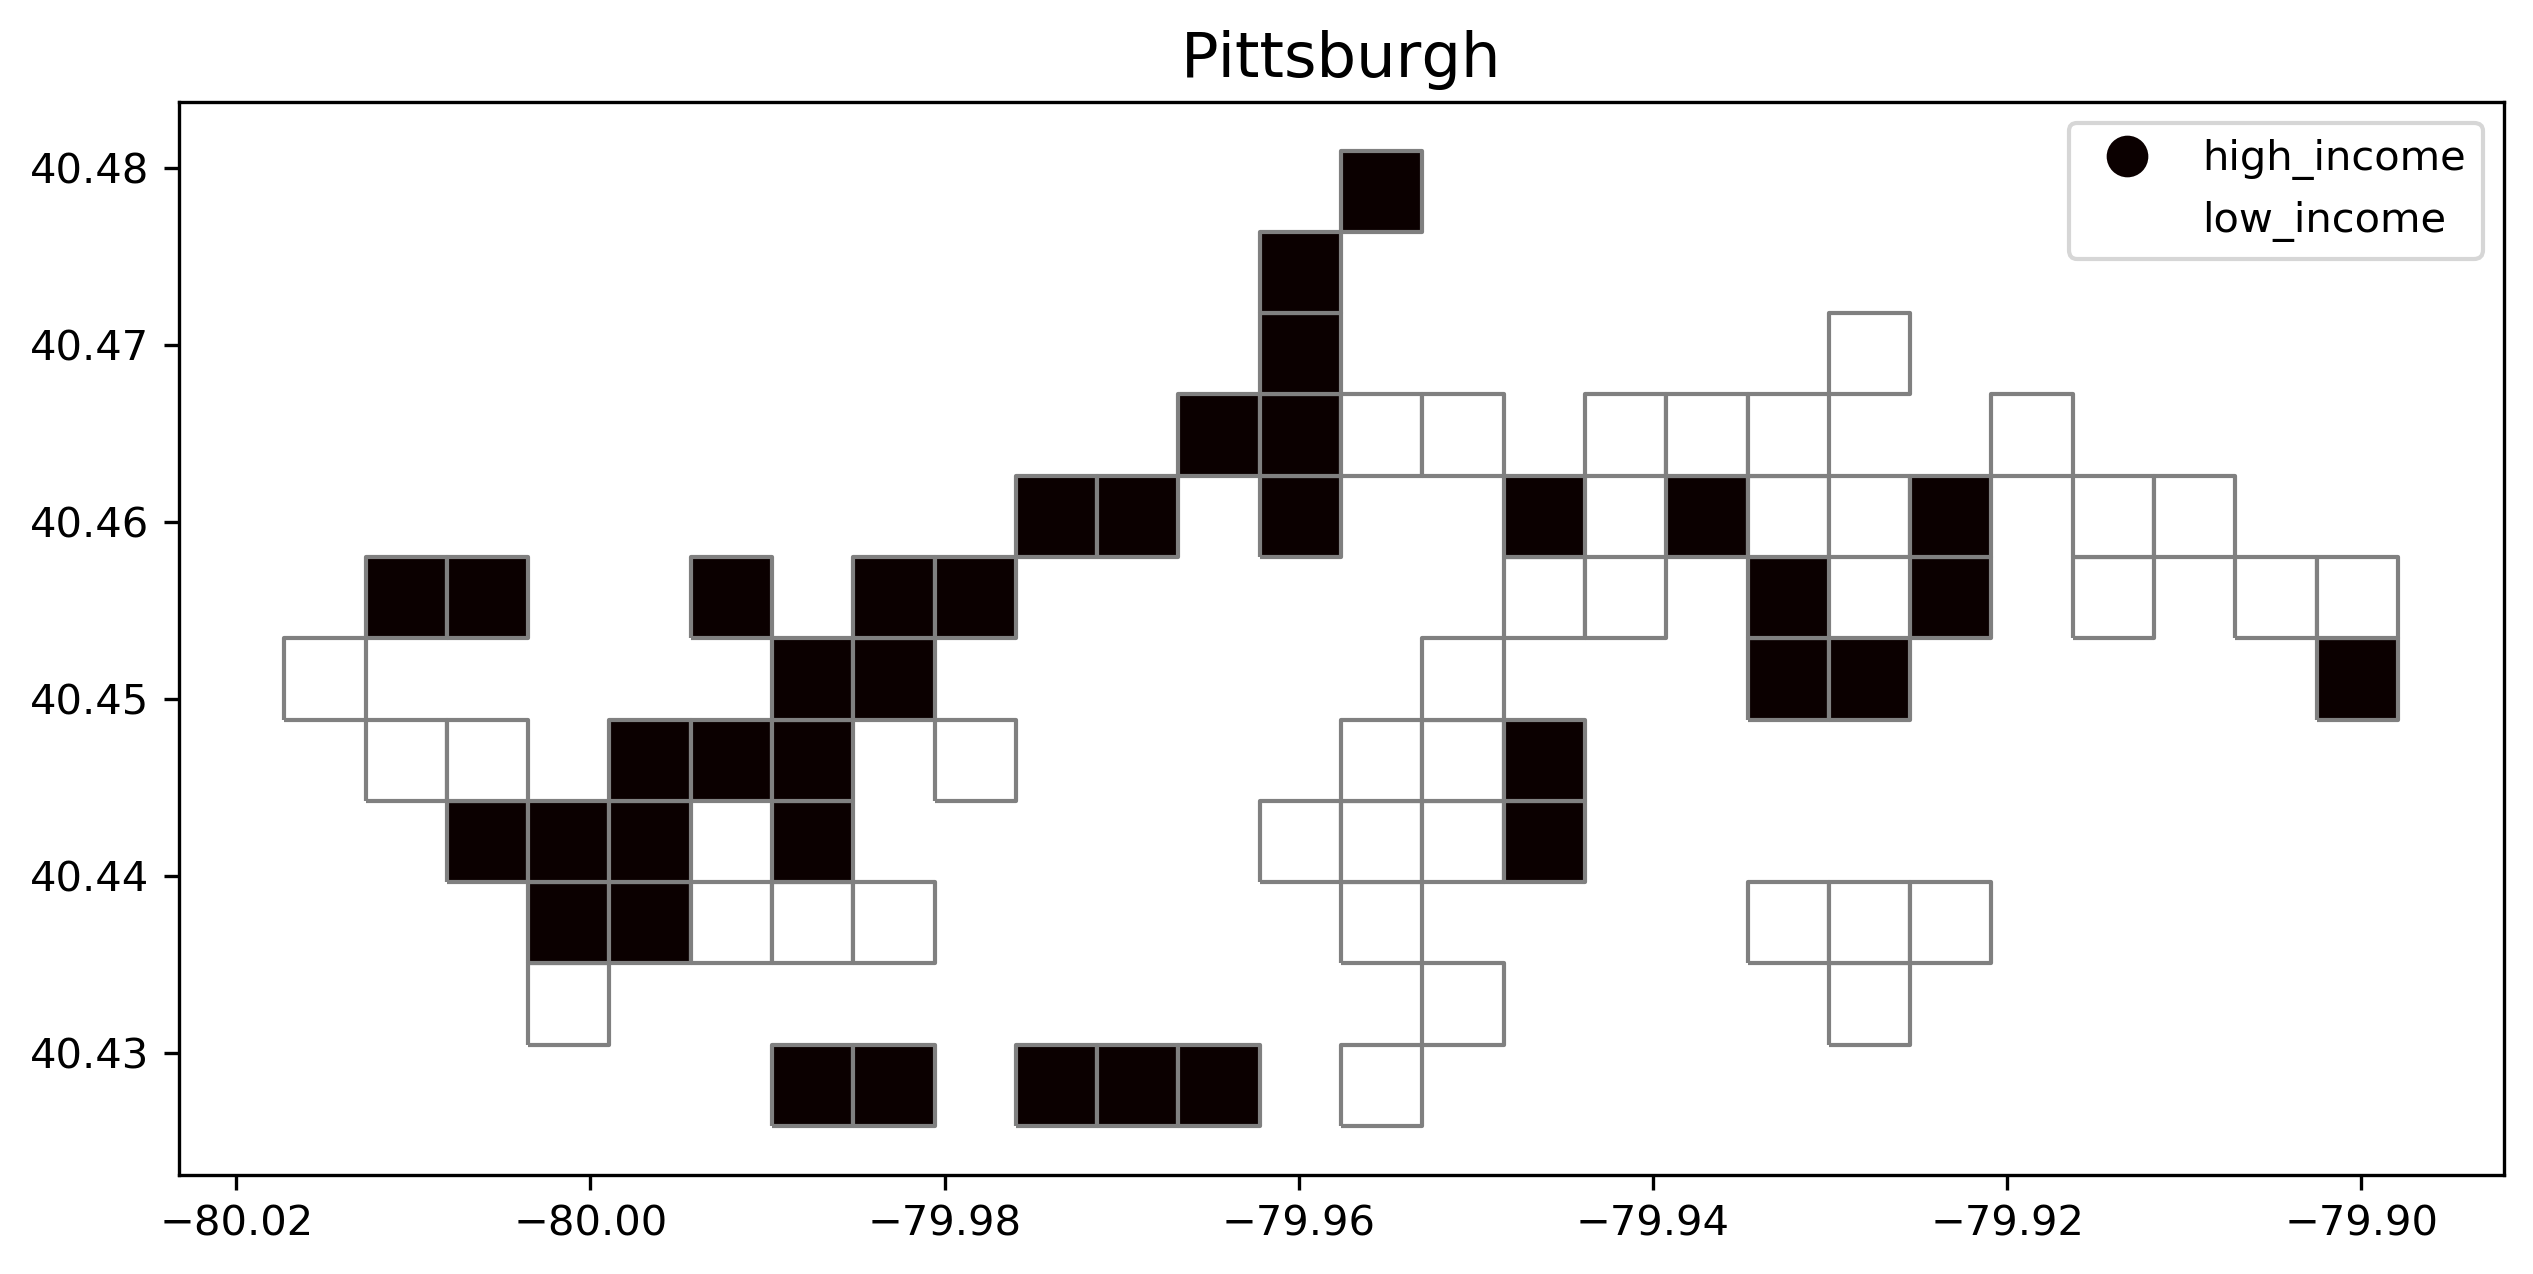

In [78]:
# income
income_df = pd.DataFrame({"cell_num": df_19.cell_num.values,
                            "income": df_19.income_group.values})
income_df = income_df.groupby("cell_num").sum()
income_df_plot = income_df.merge(geo_df, how='left', on = 'cell_num')
geo_cells_income = gpd.GeoDataFrame(income_df_plot, crs='EPSG:2956', geometry='geometry')
# type(pgh_grid_income.loc[0]['geometry'])
geo_cells_income["bi_income"] = geo_cells_income["income"].apply(lambda x: "high_income" if x > 0 else "low_income")
geo_cells_income.plot(column="bi_income", cmap='hot', edgecolor = "grey", figsize=(10, 8),  
                    legend = True, categorical = True)
plt.title("Pittsburgh", fontsize = 15)
plt.savefig("pitt_income")

In [77]:
income_df_plot.bi_income.describe()

count              76
unique              2
top       high_income
freq               39
Name: bi_income, dtype: object

In [78]:
39/76

0.5131578947368421

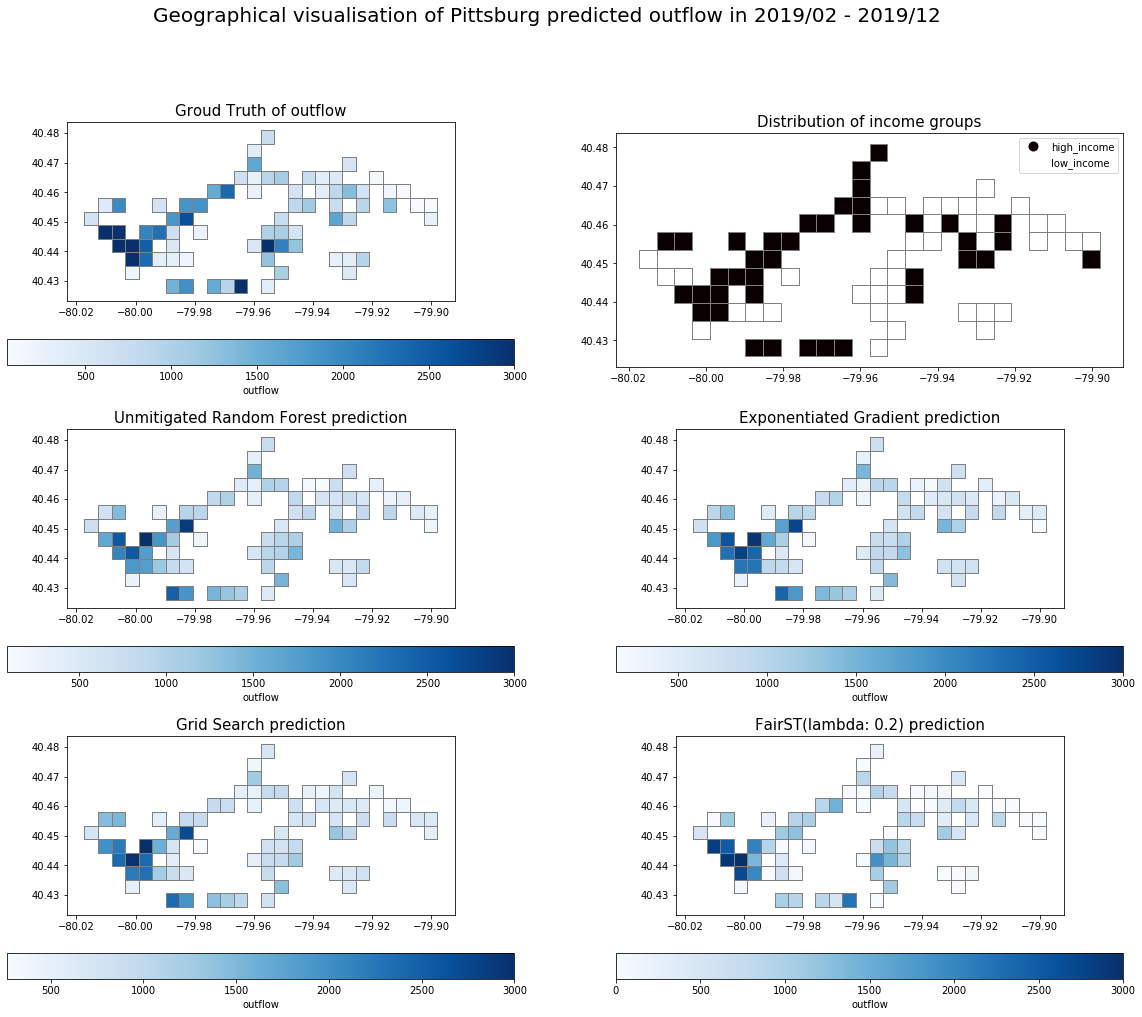

In [79]:
fig, axes = plt.subplots(3,2, figsize = (20, 16))

ax1=axes[0,0]
ax2=axes[0,1]
ax3=axes[1,0]
ax4=axes[1,1]
ax5=axes[2,0]
ax6=axes[2,1]

geo_cells_unmitigated.plot(column="y_true", cmap='Blues',edgecolor = "grey", figsize=(8,5), legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, ax = ax1, vmax = 3000)
ax1.set_title("Groud Truth of outflow", size = 15)

geo_cells_income.plot(column="bi_income", cmap='hot', edgecolor = "grey", figsize=(5, 3), legend = True, categorical = True, ax = ax2)
ax2.set_title("Distribution of income groups", size = 15)

geo_cells_unmitigated.plot(column="y_pred", cmap='Blues',edgecolor = "grey", figsize=(8,5), legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, ax = ax3, vmax = 3000)
ax3.set_title("Unmitigated Random Forest prediction", size = 15)

geo_cells_mitigated_eg.plot(column="y_pred", cmap='Blues',edgecolor = "grey", figsize=(8,5), legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, ax = ax4, vmax = 3000)
ax4.set_title("Exponentiated Gradient prediction", size = 15)

geo_cells_mitigated_gs.plot(column="y_pred", cmap='Blues',edgecolor = "grey", figsize=(8,5), legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, ax = ax5, vmax = 3000)
ax5.set_title("Grid Search prediction", size = 15)

fairst_pred.plot(column="outflow", cmap='Blues',edgecolor = "grey", figsize=(8, 5), legend = True, legend_kwds={'label': "outflow", 'orientation': "horizontal"}, ax = ax6, vmax = 3000)
ax6.set_title("FairST(lambda: {}) prediction".format(str(0.2)), size = 15)

fig.suptitle('Geographical visualisation of Pittsburg predicted outflow in 2019/02 - 2019/12', fontsize = 20)

plt.savefig(os.path.join(save_dir_models, CITY + "geographical_visualization"))
